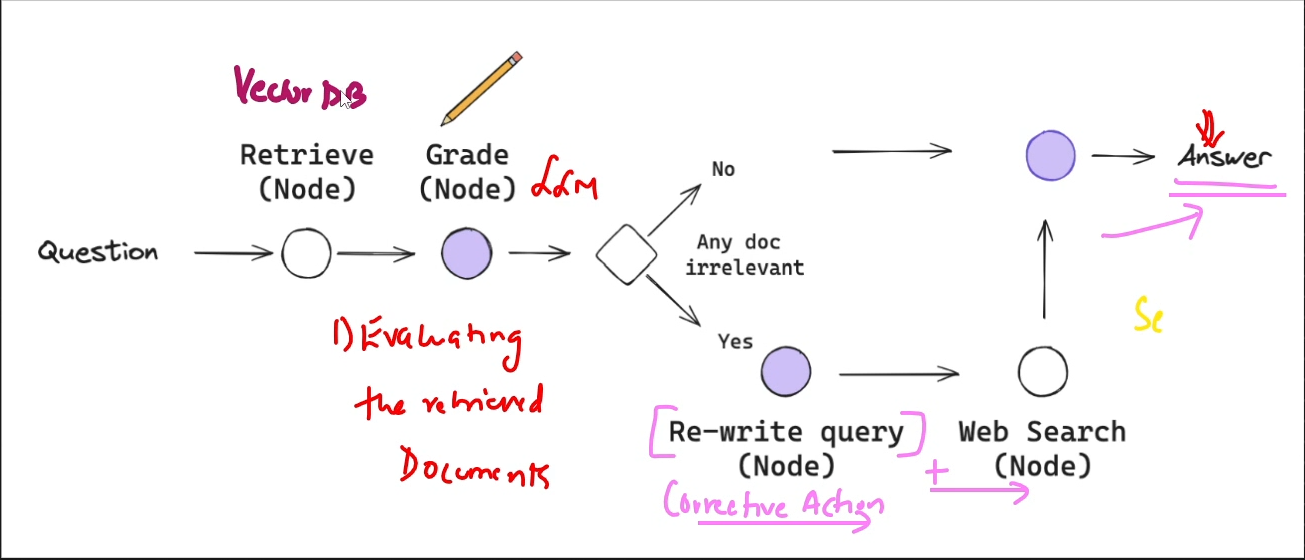

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
embedding_model=OpenAIEmbeddings(model='text-embedding-3-small')

urls=[
    'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
    'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/',
    'https://lilianweng.github.io/posts/2024-07-07-hallucination/'
]

docs=[WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]

text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,chunk_overlap=0
)
doc_splits=text_splitter.split_documents(docs_list)

vector_store=FAISS.from_documents(
    documents=doc_splits,
    embedding=embedding_model
)

retriever=vector_store.as_retriever()

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel,Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score:str=Field(
        description="Document are relevant to the question,'yes' or 'no'"
        
    )
llm=init_chat_model('groq:gemma2-9b-it')
structured_llm_grader=llm.with_structured_output(GradeDocuments)

system="""You are a grader assessing relevance of a retrieved document to a user question.\n
    if the document contains keyword(s) or semantic meaning related to the question,grade it as relevant.\n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt=ChatPromptTemplate.from_messages(
        [("system",system),
    ("human","Retrieved document: \n\n {document} \n\n User question: {question}"),]
    )

retrieved_grader=grade_prompt|structured_llm_grader
question="how llm model hallucinates?"
docs=retriever.invoke(question)
doc_text=docs[1].page_content
print(retrieved_grader.invoke({'question':question,'document':doc_text}))

binary_score='yes'


In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt=hub.pull('rlm/rag-prompt')

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain=prompt|llm|StrOutputParser()

generation=rag_chain.invoke({'context':docs,'question':question})
print(generation)

LLMs can hallucinate because their training data might contain inaccuracies or biases.  Additionally, during the training process, they learn to predict the next word in a sequence based on patterns in the data, which can lead to generating text that sounds plausible but is factually incorrect. 



In [9]:
sysytem="""you are a question re-writer that converts an input question to a better version that is optimized\n
for a web search.Look at the input and try to reason about the underlying semantic intent/meaning."""
re_write_prompt=ChatPromptTemplate.from_messages(
    [
        ('system',system),
        (
            'human',
            "Here is the initial question: \n\n {question} \n formulate an improved question.",
        )
    ]
)

question_rewriter=re_write_prompt|llm|StrOutputParser()
question_rewriter.invoke({'question':question})

'The provided question "how llm model hallucinates?" is already quite clear.  \n\nHere are a couple of ways you could make it even more precise, depending on the specific focus you\'re looking for:\n\n**More focused on the mechanism:**\n\n* What are the underlying causes of hallucinations in large language models? \n* How do the training processes of LLMs contribute to hallucinations?\n\n**More focused on the types of hallucinations:**\n\n* What are common examples of hallucinations produced by LLMs?\n* How can we classify different types of hallucinations in LLMs?\n\n**More focused on mitigating hallucinations:**\n\n* What techniques are being explored to reduce hallucinations in LLMs?\n* How effective are current methods for addressing hallucinations in LLMs?\n\n\nLet me know if you have a particular aspect of LLMs hallucinating that you\'d like to explore further! \n\n'

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool=TavilySearchResults(k=1)


/tmp/ipykernel_41761/326744546.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool=TavilySearchResults(k=1)


In [19]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question:str
    generation:str
    web_search:str
    documents:List[str]

In [24]:
from langchain.schema import Document
def retrieve(state):
    print("--RETRIEVE--")
    question=state["question"]

    documents=retriever.invoke(question)
    return {"documents":documents,"question":question}

def generate(state):
    print("--GENERATE--")
    question=state["question"]
    documents=state["documents"]

    generation=rag_chain.invoke({"context":documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}


def grade_documents(state):
    print("--CHECK DOCUMENT RELEVANCE TO QUESTION--")
    question=state["question"]
    documents=state['documents']

    filtered_docs=[]
    web_search="No"
    for document in documents:
        score=retrieved_grader.invoke(
            {'question':question,'document':document.page_content}
        )

        grade=score.binary_score
        if grade=='yes':
            print("--GRADE: DOCUMENT RELEVANT--")
            filtered_docs.append(document)
        else:
            print("--GRADE: DOCUMENT NOT RELEVANT")
    return {'document':filtered_docs,'question':question,'web_search':web_search}




def transform_query(state):
    print("--TRANSFORM QUERY--")
    question=state['question']
    document=state['documents']

    better_question=question_rewriter.invoke({'question':question})
    return {'document':document,'question':better_question}


def web_search(state):
    print("---WEB SEARCH--")
    question=state['question']
    documents=state['documents']

    docs=web_search_tool.invoke({'query':question})
    web_results="\n".join(document['content'] for document in docs)
    web_results=Document(page_content=web_results)
    documents.append(web_results)

    return {'documents':documents,'question':question}


def decide_to_generate(state):
    print("--ASSESS GRADED DOCUMENTS--")
    state['question']
    web_search=state['web_search']
    state['documents']

    if web_search=="Yes":
        print("--DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION,TRANSFORM QUERY--")
    
        return  "transform_query"
    else:
        print("--DECISION: GENERATE--")
        return "generate"
    

In [25]:
from langgraph.graph import START,StateGraph,END

workflow=StateGraph(GraphState)

workflow.add_node('retrieve',retrieve)
workflow.add_node('grade_documents',grade_documents)
workflow.add_node('generate',generate)
workflow.add_node('transform_query',transform_query)
workflow.add_node('web_search_node',web_search)


workflow.add_edge(START,'retrieve')
workflow.add_edge('retrieve','grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {
        'transform_query':'transform_query',
        'generate':'generate'
    },
)
workflow.add_edge('transform_query','web_search_node')
workflow.add_edge('web_search_node','generate')
workflow.add_edge('generate',END)

app=workflow.compile()

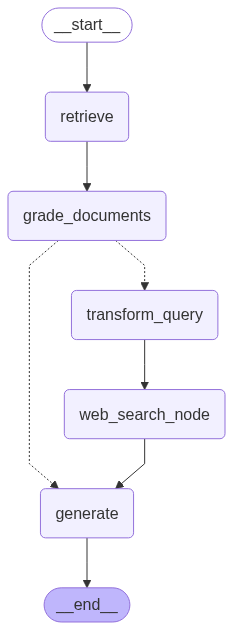

In [26]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
app.invoke({'question':"What are the types of Adversarial Attacks"})

--RETRIEVE--
--CHECK DOCUMENT RELEVANCE TO QUESTION--
--GRADE: DOCUMENT RELEVANT--
--GRADE: DOCUMENT RELEVANT--
--GRADE: DOCUMENT RELEVANT--
--GRADE: DOCUMENT RELEVANT--
--ASSESS GRADED DOCUMENTS--
--DECISION: GENERATE--
--GENERATE--


{'question': 'What are the types of Adversarial Attacks',
 'generation': "The document provides a list of types of adversarial attacks on LLMs. Here are some of them: \n* **Token Manipulation:** Changing individual words in the input text to slightly alter the model's output.\n* **Gradient-based Attacks:**  These attacks leverage gradients to find adversarial examples.\n* **Jailbreak Prompting:** Crafting prompts to bypass safety mechanisms in the model.\n* **Humans in the Loop Red-teaming:** Humans help create adversarial examples.\n* **Model Red-teaming:**  Training a model to attack another LLM. \n\n",
 'web_search': 'No',
 'documents': [Document(id='dc0e7fd0-deae-48a3-a99b-63c1db1e426b', metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'title': "Adversarial Attacks on LLMs | Lil'Log", 'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to t